In [3]:
import tensorflow as tf

In [1]:
import numpy as np 
import pandas as pd 
import scipy
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform
from __future__ import print_function, division

from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import datetime
import sys
import os
from imageio import imread


In [2]:
print(os.listdir("/content/drive/MyDrive/brain tumor segmentation/huzaifa data/SPADE Data/val"))

['img', 'msk']


In [3]:
def build_generator():
        """U-Net Generator"""

        def conv2d(layer_input, filters, f_size=4, bn=True):
            """Layers used during downsampling"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if bn:
                d = BatchNormalization(momentum=0.8)(d)
            return d

        def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
            """Layers used during upsampling"""
            u = UpSampling2D(size=2)(layer_input)
            u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
            if dropout_rate:
                u = Dropout(dropout_rate)(u)
            u = BatchNormalization(momentum=0.8)(u)
            u = Concatenate()([u, skip_input]) #skip connection
            return u

        
        d0 = Input(shape=img_shape)

        # Downsampling
        d1 = conv2d(d0, gf, bn=False)
        d2 = conv2d(d1, gf*2)
        d3 = conv2d(d2, gf*4)
        d4 = conv2d(d3, gf*8)
        d5 = conv2d(d4, gf*8)
        d6 = conv2d(d5, gf*8)
        d7 = conv2d(d6, gf*8)

        # Upsampling
        u1 = deconv2d(d7, d6, gf*8)
        u2 = deconv2d(u1, d5, gf*8)
        u3 = deconv2d(u2, d4, gf*8)
        u4 = deconv2d(u3, d3, gf*4)
        u5 = deconv2d(u4, d2, gf*2)
        u6 = deconv2d(u5, d1, gf)

        u7 = UpSampling2D(size=2)(u6)
        output_img = Conv2D(channels, kernel_size=4, strides=1, padding='same', activation='tanh')(u7)

        return Model(d0, output_img)

In [4]:
def build_discriminator():
        # a small function to make one layer of the discriminator
        def d_layer(layer_input, filters, f_size=4, bn=True):
            """Discriminator layer"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if bn:
                d = BatchNormalization(momentum=0.8)(d)
            return d

        img_A = Input(shape=img_shape)
        img_B = Input(shape=img_shape)

        # Concatenate image and conditioning image by channels to produce input
        combined_imgs = Concatenate(axis=-1)([img_A, img_B])

        d1 = d_layer(combined_imgs, df, bn=False)
        d2 = d_layer(d1, df*2)
        d3 = d_layer(d2, df*4)
        d4 = d_layer(d3, df*8)

        validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

        return Model([img_A, img_B], validity)

In [5]:
# Input shape
img_rows = 128
img_cols = 128
channels = 3
img_shape = (img_rows, img_cols, channels)


# Calculate output shape of D (PatchGAN)
patch = int(img_rows / 2**4)
disc_patch = (patch, patch, 1)

# Number of filters in the first layer of G and D
gf = 64
df = 64

optimizer = Adam(0.0002, 0.5)

# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])

# Build the generator
generator = build_generator()

# Input images and their conditioning images
img_A = Input(shape=img_shape)
img_B = Input(shape=img_shape)

# By conditioning on B generate a fake version of A
fake_A = generator(img_B)

# For the combined model we will only train the generator
discriminator.trainable = False

# Discriminators determines validity of translated images / condition pairs
valid = discriminator([fake_A, img_B])

combined = Model(inputs=[img_A, img_B], outputs=[valid, fake_A])
combined.compile(loss=['mse', 'mae'],
                              loss_weights=[1, 100],
                              optimizer=optimizer)

In [17]:
import os
import numpy as np


def load_img(img_dir, img_list):
    images=[]
    for i, image_name in enumerate(img_list):    
        if (image_name.split('.')[1] == 'npy'):
            
            image = np.load(img_dir+image_name)
                      
            images.append(image)
    images = np.array(images)
    
    return(images)




def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):

    L = len(img_list)

    #keras needs the generator infinite, so we will use while true  
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
                       
            X = load_img(img_dir, img_list[batch_start:limit])
            Y = load_img(mask_dir, mask_list[batch_start:limit])

            yield (X,Y) #a tuple with two numpy arrays with batch_size samples     

            batch_start += batch_size   
            batch_end += batch_size


In [11]:
import random

In [ ]:
#Define the image generators for training and validation

train_img_dir = "/content/drive/MyDrive/brain tumor segmentation/huzaifa data/SPADE Data/train/img/"
train_mask_dir = "/content/drive/MyDrive/brain tumor segmentation/huzaifa data/SPADE Data/train/msk/"

##val_img_dir = "/content/drive/MyDrive/brain tumor segmentation/huzaifa data/SPADE Data/val/img"
#val_mask_dir = "/content/drive/MyDrive/brain tumor segmentation/huzaifa data/SPADE Data/val/msk/"

train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

#val_img_list=os.listdir(val_img_dir)
#val_mask_list = os.listdir(val_mask_dir)
##################################

########################################################################
batch_size = 1

'''train_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

#val_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                #val_mask_dir, val_mask_list, batch_size)

#Verify generator.... In python 3 next() is renamed as __next__()
img, msk = train_img_datagen.__next__()

img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
#test_mask=np.argmax(test_mask, axis=3)

##n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:])
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_mask[:,:])
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()'''

In [18]:
def load_data(batch_size=1):
  pth1 = '/content/drive/MyDrive/brain tumor segmentation/huzaifa data/SPADE Data/train/img'
  pth2 = '/content/drive/MyDrive/brain tumor segmentation/huzaifa data/SPADE Data/train/msk'
  imgs = np.random.choice(pth1, size=batch_size)
  msks = np.random.choice(pth2, size=batch_size)
  return imgs, msks

In [6]:
def show_images(epoch, batch_i):
        
        r, c = 3, 3

        imgs_A, imgs_B = load_data(batch_size=3)
        fake_A = generator.predict(imgs_B)

        gen_imgs = np.concatenate([imgs_B, fake_A, imgs_A])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        titles = ['Input', 'Output', 'Ground Truth']
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt])
                axs[i, j].set_title(titles[i])
                axs[i,j].axis('off')
                cnt += 1
        plt.show()
        plt.close()

In [14]:
img_rows = 128
img_cols = 128
channels = 3
img_shape = (img_rows, img_cols, channels)


# Calculate output shape of D (PatchGAN)
patch = int(img_rows / 2**4)
disc_patch = (patch, patch, 1)

# Number of filters in the first layer of G and D
gf = 64
df = 64

optimizer = Adam(0.0002, 0.5)

# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])

# Build the generator
generator = build_generator()

# Input images and their conditioning images
img_A = Input(shape=img_shape)
img_B = Input(shape=img_shape)

# By conditioning on B generate a fake version of A
fake_A = generator(img_B)

# For the combined model we will only train the generator
discriminator.trainable = False

# Discriminators determines validity of translated images / condition pairs
valid = discriminator([fake_A, img_B])

combined = Model(inputs=[img_A, img_B], outputs=[valid, fake_A])
combined.compile(loss=['mse', 'mae'],
                              loss_weights=[1, 100],
                              optimizer=optimizer)

In [20]:
def train(epochs, batch_size=1, show_interval=10):

        start_time = datetime.datetime.now()

        # Adversarial loss ground truths
        valid = np.ones((batch_size,) + disc_patch)
        fake = np.zeros((batch_size,) + disc_patch)

        for epoch in range(epochs):
            for batch_i, (imgs_A, imgs_B) in enumerate(imageLoader(train_img_dir, train_img_list,
                                                                   train_mask_dir, train_mask_list, batch_size)):

                
                #  Train Discriminator
                

                # Condition on B and generate a translated version
                fake_A = generator.predict(imgs_B)

                # Train the discriminators (original images = real / generated = Fake)
                d_loss_real = discriminator.train_on_batch([imgs_A, imgs_B], valid)
                d_loss_fake = discriminator.train_on_batch([fake_A, imgs_B], fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

               
                #  Train Generator
                g_loss = combined.train_on_batch([imgs_A, imgs_B], [valid, imgs_A])

                elapsed_time = datetime.datetime.now() - start_time
                
            # Plot the progress
            if epoch%10==0:
                  print ("[Epoch %d/%d]  [D loss: %f, acc: %3d%%] [G loss: %f] time: %s" % (epoch, epochs,
                                                                        
                                                                        d_loss[0], 100*d_loss[1],
                                                                        g_loss[0],
                                                                        elapsed_time))
            # If at show interval => show generated image samples
            if epoch % show_interval == 0:
                    show_images(dataset_name,epoch, batch_i)

In [22]:
train(epochs=50, batch_size=8, show_interval=10)

ValueError: ignored

In [ ]:
###########################################################
''' Concatination of images and relative masks '''
###########################################################

import numpy as np
import nibabel as nib
import glob
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib

for img in range(100):   #Using t1_list as all lists are of same size
    print("Now preparing image and masks number: ", img)
      
    temp_image = np.load('/content/drive/MyDrive/brain tumor segmentation/huzaifa data/SPADE Data/train/img/image_'+str(img+201)+'.npy')
    temp_mask = np.load('/content/drive/MyDrive/brain tumor segmentation/huzaifa data/SPADE Data/train/msk/mask_'+str(img+201)+'.npy')
    #im_frame = Image.open('/content/drive/MyDrive/brain tumor segmentation/huzaifa data/SPADE Data/val/img/image_'+str(img+150)+'.png')
    #msk_frame = Image.open('/content/drive/MyDrive/brain tumor segmentation/huzaifa data/SPADE Data/val/msk/mask_'+str(img)+'.png')
    temp_combined_image = np.hstack((temp_image, temp_mask))
    #im_np_frame = np.array(im_frame.getdata())
    #msk_np_frame = np.array(msk_frame.getdata())



    #matplotlib.image.imsave('/content/drive/MyDrive/brain tumor segmentation/huzaifa data/SPADE Data/val/img/'+str(img)+'.png', temp_image)
    matplotlib.image.imsave('/content/drive/MyDrive/brain tumor segmentation/huzaifa data/SPADE Data/cnctntd_imgs/'+str(img)+'_m.png', temp_combined_image)


In [23]:
    temp_image = np.load('/content/drive/MyDrive/brain tumor segmentation/huzaifa data/SPADE Data/train/img/image_'+str(201)+'.npy')
    temp_mask = np.load('/content/drive/MyDrive/brain tumor segmentation/huzaifa data/SPADE Data/train/msk/mask_'+str(201)+'.npy')

In [26]:
comb1 = np.hstack((temp_image, temp_mask))
#comb2 = np.concatenate(temp_image, temp_mask)

In [27]:
import matplotlib.pyplot as plt


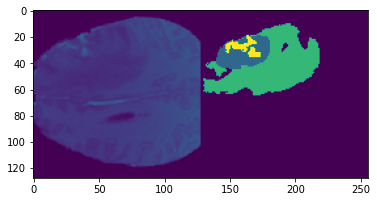

In [28]:
plt.imshow(comb1)